In [ ]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

In [ ]:
path = '/content/sample_data/text.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 376592


In [ ]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 71


In [ ]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 125518


In [ ]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
sentences[100]


'nberg license included with this ebook o'

In [ ]:
next_chars[100]


'r'

In [ ]:
X[0][0]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
y[0]


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
X.shape



(125518, 40, 71)

In [ ]:
y.shape


(125518, 71)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [ ]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
932/932 [==============================] - 102s 107ms/step - loss: 2.1394 - accuracy: 0.3634 - val_loss: 1.8908 - val_accuracy: 0.4316
Epoch 2/10
932/932 [==============================] - 99s 106ms/step - loss: 1.7495 - accuracy: 0.4651 - val_loss: 1.7315 - val_accuracy: 0.4712
Epoch 3/10
932/932 [==============================] - 99s 106ms/step - loss: 1.6212 - accuracy: 0.5010 - val_loss: 1.6789 - val_accuracy: 0.4901
Epoch 4/10
932/932 [==============================] - 99s 106ms/step - loss: 1.5501 - accuracy: 0.5230 - val_loss: 1.6499 - val_accuracy: 0.5013
Epoch 5/10
932/932 [==============================] - 100s 107ms/step - loss: 1.5031 - accuracy: 0.5350 - val_loss: 1.6318 - val_accuracy: 0.5035
Epoch 6/10
932/932 [==============================] - 100s 107ms/step - loss: 1.4713 - accuracy: 0.5442 - val_loss: 1.6298 - val_accuracy: 0.5091
Epoch 7/10
932/932 [==============================] - 99s 107ms/step - loss: 1.4432 - accuracy: 0.5523 - val_loss: 1.6269 - val

In [ ]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [ ]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

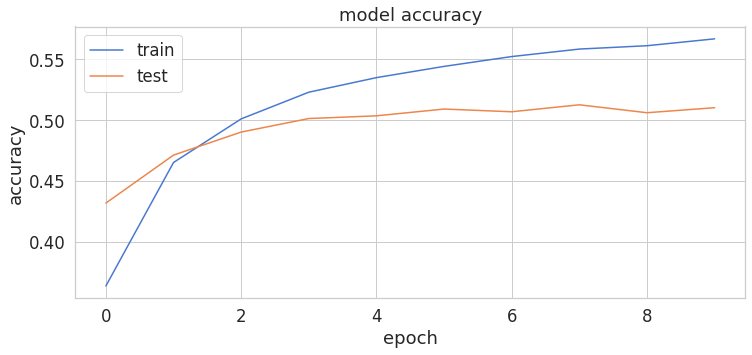

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

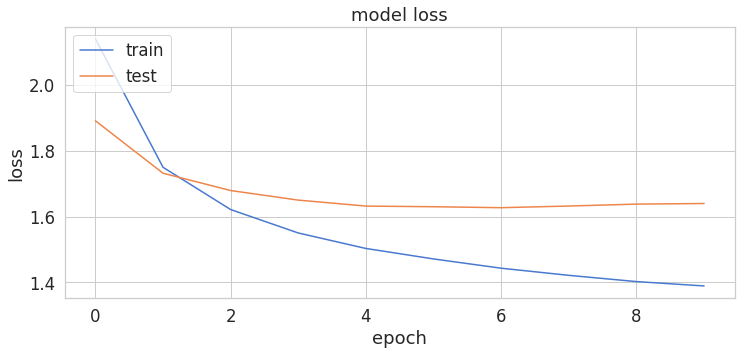

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [ ]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [ ]:
prepare_input("This is an example of input for our LSTM".lower())


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
quotes = [
      "Não é falta de amor, mas sim de amizade que torna os casamentos infelizes.",
     "Aquilo que não nos mata nos torna mais fortes.",
     "Não estou chateado por você ter mentido para mim, estou chateado que a partir de agora não posso acreditar em você.",
     "E aqueles que foram vistos dançando foram considerados loucos por aqueles que não podiam ouvir a música.",
     "Já é bastante difícil lembrar minhas opiniões, sem lembrar também minhas razões para elas!"  
]

In [ ]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 3))
    print()

não é falta de amor, mas sim de amizade 
['de ', 'e ', 'a ']

aquilo que não nos mata nos torna mais f
['inal ', 'alava ', 'orças ']

não estou chateado por você ter mentido 
['de ', 'e ', 'a ']

e aqueles que foram vistos dançando fora
['m ', ' de ', 'l-o ']

já é bastante difícil lembrar minhas opi
['nião; ', 'ras ', 'as ']

